## Packages

In [5]:
import os
import zipfile
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

## Seismic Fault Detection on Synthetic Data

### Creating Synthetic Data

In [19]:
num_samples = 1000 
x_trainSyn = np.zeros((num_samples, 128, 128, 1))
y_trainSyn = np.zeros((num_samples, 128, 128, 1))

for i in range(num_samples):
    image = np.random.normal(0.5, 0.15, (128, 128))  # Bright and dim spots
    noise = np.random.normal(0, 0.02, (128, 128))  # Gaussian Noise: 2% noise
    image = np.clip(image + noise, 0, 1)
    mask = np.zeros((128, 128))
    for _ in range(np.random.randint(3, 8)):
        x1, y1 = np.random.randint(0, 128, 2)
        x2, y2 = np.random.randint(0, 128, 2)
        cv2.line(mask, (x1, y1), (x2, y2), 1, 2)
    x_trainSyn[i] = np.expand_dims(image, axis=-1)
    y_trainSyn[i] = np.expand_dims(mask, axis=-1)

## Noise Reduction using OpenCV Techniques --> Gaussian Blur
x_trainSyn = np.array([cv2.GaussianBlur(img.squeeze(), (3, 3), 0).reshape(128, 128, 1) for img in x_trainSyn])

### Visualise the Synthetic Data

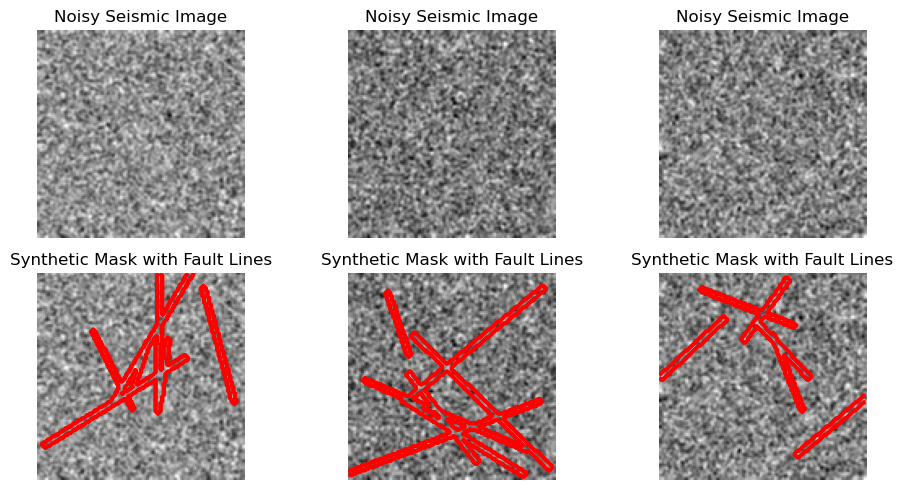

In [20]:
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_trainSyn[i].squeeze(), cmap='gray')
    plt.title('Noisy Seismic Image')
    plt.axis('off')

    plt.subplot(2, 3, i + 4)
    plt.imshow(x_trainSyn[i].squeeze(), cmap='gray')
    plt.contour(y_trainSyn[i].squeeze(), colors='red', linewidths=2)
    plt.title('Synthetic Mask with Fault Lines')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
x_trainSyn, x_cvSyn, y_trainSyn, y_cvSyn = train_test_split(x_trainSyn, y_trainSyn, test_size=0.2, random_state=42)

### U-Net

In [12]:
def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u1 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    u2 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u2)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │      8,224 │ conv2d_4[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     18,464 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │      2,064 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │      4,624 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │         17 │ conv2d_6[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 68,257 (266.63 KB)

 Trainable params: 68,257 (266.63 KB)

 Non-trainable params: 0 (0.00 B)

### Model training and Evaluation

In [27]:
history = model.fit(x_trainSyn, y_trainSyn, validation_data=(x_cvSyn, y_cvSyn), epochs=10)

loss, pixel_accuracy = model.evaluate(x_cvSyn, y_cvSyn)
print(f"Validation Loss: {loss:.4f}, Pixel-wise Accuracy: {pixel_accuracy:.4f}")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9424 - loss: 0.2123 - val_accuracy: 0.9399 - val_loss: 0.2187
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9410 - loss: 0.2159 - val_accuracy: 0.9399 - val_loss: 0.2187
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9409 - loss: 0.2164 - val_accuracy: 0.9399 - val_loss: 0.2187
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9419 - loss: 0.2135 - val_accuracy: 0.9399 - val_loss: 0.2187
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9412 - loss: 0.2151 - val_accuracy: 0.9399 - val_loss: 0.2187
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9421 - loss: 0.2128 - val_accuracy: 0.9399 - val_loss: 0.2187
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9413 - loss: 0.2151 - val_accuracy: 0.9399 - val_loss: 0.2186
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9417 - loss: 0.2141 - val_accuracy: 0.9399 - val_loss:

In [29]:
preds = model.predict(x_cvSyn)
fault_flags_true = [(1 if np.sum(y.squeeze()) > 50 else 0) for y in y_cvSyn]
fault_flags_pred = [(1 if np.sum(pred.squeeze() > 0.5) > 50 else 0) for pred in preds]
fault_accuracy = np.mean([1 if t == p else 0 for t, p in zip(fault_flags_true, fault_flags_pred)])
print(f"Fault Detection Accuracy (Presence/Absence): {fault_accuracy:.4f}")

complete_fault_accuracy = np.mean([np.array_equal((pred.squeeze() > 0.5).astype(int), y.squeeze().astype(int)) for pred, y in zip(preds, y_cvSyn)])
print(f"Complete Fault Detection Accuracy: {complete_fault_accuracy:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step
Fault Detection Accuracy (Presence/Absence): 0.0000
Complete Fault Detection Accuracy: 0.0000


### Prediction Visualisation

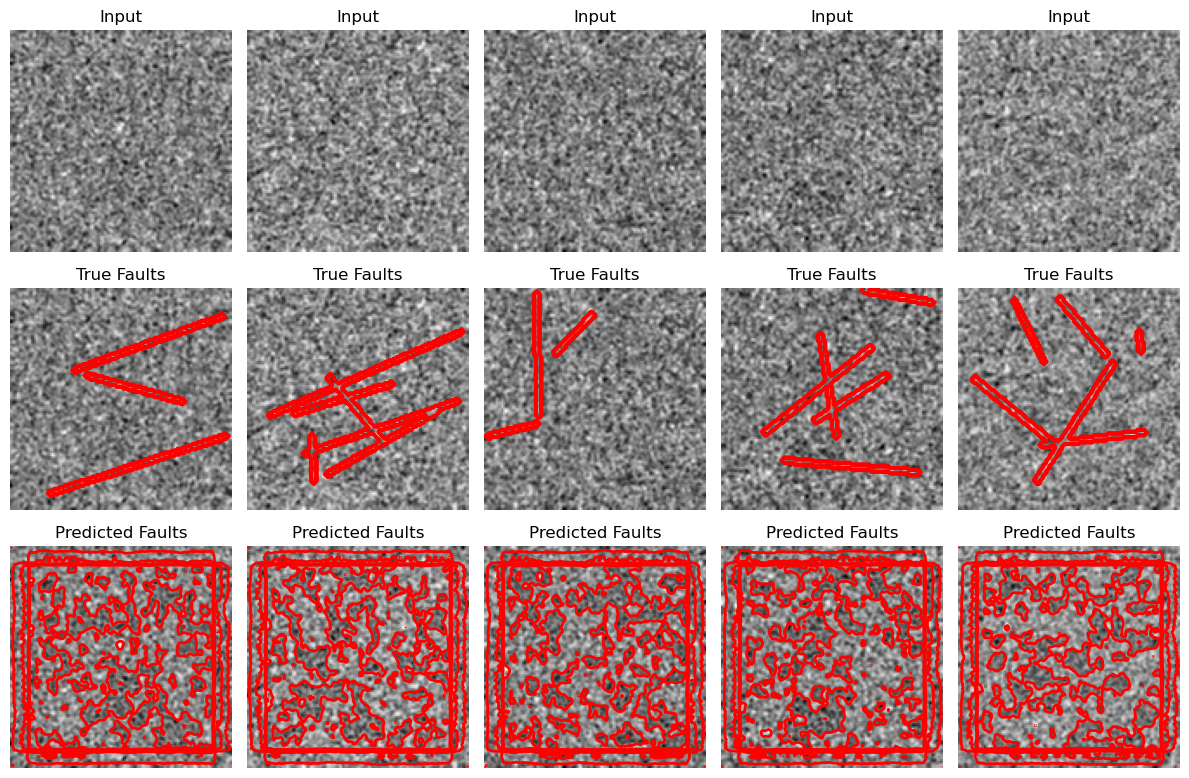

In [24]:
plt.figure(figsize=(12, 8))
fault_flags = []
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_cvSyn[i].squeeze(), cmap='gray')
    plt.title('Input')
    plt.axis('off')

    plt.subplot(3, 5, i + 6)
    plt.imshow(x_cvSyn[i].squeeze(), cmap='gray')
    plt.contour(y_cvSyn[i].squeeze(), colors='red', linewidths=2)
    plt.title('True Faults')
    plt.axis('off')

    plt.subplot(3, 5, i + 11)
    plt.imshow(x_cvSyn[i].squeeze(), cmap='gray')
    plt.contour(preds[i].squeeze(), colors='red', linewidths=2)
    plt.title('Predicted Faults')
    plt.axis('off')
plt.tight_layout()
plt.show()